# Difference Map

This notebook explores the calculations needed to plot the Difference Map in the Project Dashboard  
**Create multiple scenarios:** create some dummy scenario data for comparisons  
**Difference Map function:** make the calculations needed for the Difference Map.  
**Plot Difference map:** example of visualization with bivariate map

The assumption is that each planning unit should fall into just one category.  

In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

%run marxan_utils.ipynb

In [2]:
df = pd.DataFrame(np.random.randint(0,100,size=(100, 2)), columns=list('AB'))
df['diff-AB'] = df.apply(lambda x: (x.A-x.B), axis=1)

/opt/conda/lib/python3.8/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


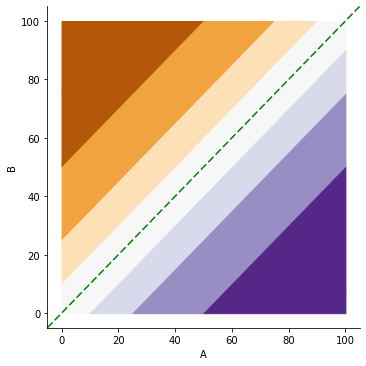

In [3]:
def plotDiffDist(df, x, y, ax):
    g = sns.relplot(data=df, x=x, y=y, ax = ax)
    g.ax.axline(xy1=(0, 0), slope=1, color="g", dashes=(5, 2))

    g.ax.fill_between(x=(0, 50),y1=[50,100],y2=[100,100], color="#b35806")
    g.ax.fill_between(x=(0, 50, 75),y1=[25,75,100],y2=[50,100,100], color="#f1a340")
    g.ax.fill_between(x=(0, 75, 90),y1=[10,85,100],y2=[25,100,100], color="#fee0b6")
    g.ax.fill_between(x=(0, 10, 90,100),y1=[0,0,75,90],y2=[10,20,100,100], color="#f7f7f7")
    g.ax.fill_between(x=(10, 25, 100),y1=[0,0,75],y2=[0,15,90], color="#d8daeb")
    g.ax.fill_between(x=(25, 50, 100),y1=[0,0,50],y2=[0,25,75], color="#998ec3")
    g.ax.fill_between(x=(50, 100),y1=[0,0],y2=[0,50], color="#542788")
    return g

plotDiffDist(df, 'A', 'B', ax=None)

<AxesSubplot:xlabel='diff-AB', ylabel='Frequency'>

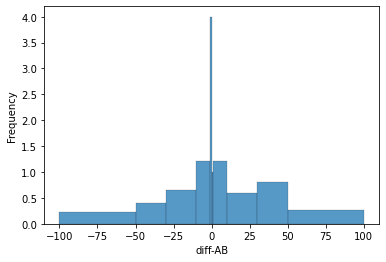

In [4]:
sns.histplot(data=df['diff-AB'], stat='frequency', bins=[-100,-50,-30,-10,-1,0,1,10,30,50,100])

## Create multiple scenarios

In [5]:
# Scenario 1
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario1'
Input,pu,spec,puvsp,bound = validate_all_files(MARXAN_FOLDER,'input.dat')
execute_marxan(MARXAN_FOLDER)
#BLM 0.3, n = 100


Marxan v 2.43



In [6]:
# Scenario 2
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
MARXAN_INPUTDATA = 'input.dat'
userInputFile,pu,spec,puvsp,bound = validate_all_files(MARXAN_FOLDER,MARXAN_INPUTDATA)

### Modify BLM
userInputFile.BLM = 10
userInputFile.NUMREPS = 30
userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
userInputFile_df= userInputFile_df.drop('BLOCKDEFNAME')
CreateFileFromDF(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}',userInputFile_df,inputDatFile)

### Modify SPF and prop
spec.prop =0.5
spec.spf = 1
spec.head()
CreateFileFromDF(f'{MARXAN_FOLDER}/{Input.INPUTDIR}/{Input.SPECNAME}', spec, conservationFeature)

### Run Marxan
execute_marxan(MARXAN_FOLDER)

Marxan v 2.43



In [7]:
# Scenario 3
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario3'
MARXAN_INPUTDATA = 'input.dat'

userInputFile= readInput(MARXAN_FOLDER,MARXAN_INPUTDATA)
pu= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, planningUnits)
spec= validateFile(MARXAN_FOLDER,MARXAN_INPUTDATA, conservationFeature)

### Modify BLM
userInputFile.BLM = 0.01
userInputFile.NUMREPS = 100
userInputFile_df = pd.DataFrame.from_dict(userInputFile.__dict__, orient='index')
userInputFile_df= userInputFile_df.drop('BLOCKDEFNAME')
CreateFileFromDF(f'{MARXAN_FOLDER}/{MARXAN_INPUTDATA}',userInputFile_df,inputDatFile)

### Modify SPF and prop
spec.prop =0.2
spec.spf = 1
spec.head()
CreateFileFromDF(f'{MARXAN_FOLDER}/{userInputFile.INPUTDIR}/{userInputFile.SPECNAME}', spec, conservationFeature)

### Lock-in and Lock-out some PUs
import random

randomlist = []
for i in range(0,int(0.3*len(pu))):
    n = random.randrange(2,3,1)
    randomlist.append(n)

l = [0] * (len(pu) - len(randomlist))
randomlist.extend(l)
random.shuffle(randomlist)
len(randomlist)

pu['status'] = randomlist
CreateFileFromDF(f'{MARXAN_FOLDER}/{userInputFile.INPUTDIR}/{userInputFile.PUNAME}',pu,planningUnits)

### Run Marxan
execute_marxan(MARXAN_FOLDER)

Marxan v 2.43



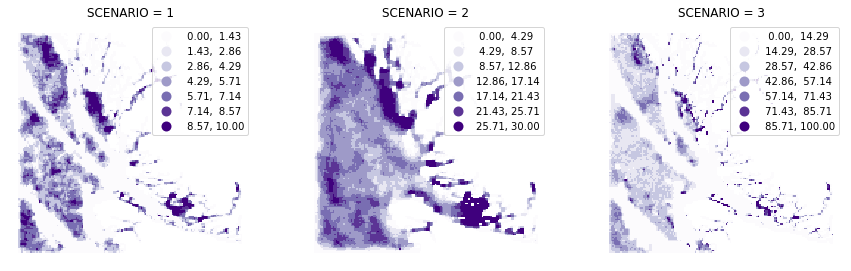

In [8]:
# Let's compare the results
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario'
scenarios = ['1','2','3']
fig, axn = plt.subplots(1, 3, figsize=(15,5))

for idx, sol in enumerate(scenarios):
    solution = pd.read_csv(f"{MARXAN_FOLDER}{sol}/output/output_ssoln.csv") #freq
    pu_area = gpd.read_file(f'{MARXAN_FOLDER}{sol}/pu/pulayer.shp')
    solution_grid = pu_area.merge(solution,left_on='PUID',right_on = 'planning_unit',how='inner')
    solution_grid.plot(ax=axn[idx],column='number', scheme='equal_interval', k=7, legend=True, cmap='Purples')
    axn[idx].set_title(f'SCENARIO = {sol}')
    axn[idx].set_axis_off();


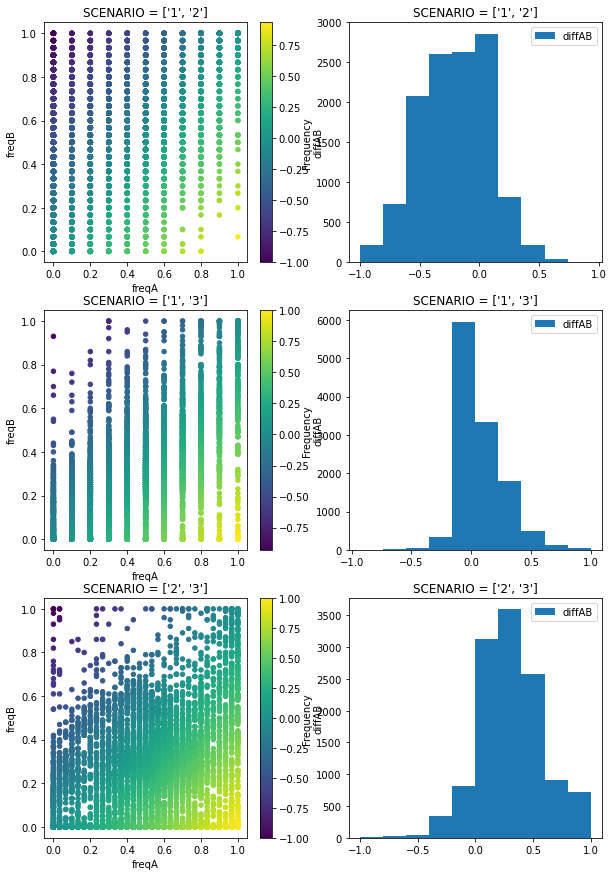

In [9]:
MARXAN_FOLDER = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario'
scenarios = [['1','2'],['1','3'],['2','3']]
norm_scenarios = {
    '1': 10,
    '2': 30,
    '3': 100
}
fig = plt.figure(figsize=(10,15))

for idx, sol in enumerate(scenarios):
    axn = fig.add_subplot(321+(2*idx))
    solutionA = pd.read_csv(f"{MARXAN_FOLDER}{sol[0]}/output/output_ssoln.csv") #count
    solutionB = pd.read_csv(f"{MARXAN_FOLDER}{sol[1]}/output/output_ssoln.csv") #count
    solution_grid = solutionA.merge(solutionB,left_on='planning_unit',right_on = 'planning_unit',how='inner')
    solution_grid['freqA'] = (solution_grid['number_x']/norm_scenarios[sol[0]])
    solution_grid['freqB'] = (solution_grid['number_y']/norm_scenarios[sol[1]])
    solution_grid['freqmA'] = (solution_grid['number_y']/norm_scenarios[sol[1]])*-1
    solution_grid['diffAB'] = solution_grid['freqA'] - solution_grid['freqB']
    solution_grid.plot.scatter(ax=axn, x='freqA',y='freqB', c= 'diffAB',colormap='viridis', legend=True)
    axn.set_title(f'SCENARIO = {sol}')
    axn = fig.add_subplot(321+((2*idx)+1))
    solution_grid["diffAB"].plot.hist(ax=axn, legend=True)
    axn.set_title(f'SCENARIO = {sol}')

### Difference Map function (update 15th June, with Bvariate Map)
Categories: 
+ Never
+ Always
+ Bivariate cloropleth (each Scenario divided in 4 classes of equal interval 0-0.25-0.5-0.75-1)

Follow this example for [bivariate cloroplepth](https://github.com/zorzalerrante/mapas_censo_2017/blob/master/Coropletas%20Bivariable.ipynb)

In [10]:
import spectra
import mapclassify
import shapely
import matplotlib.patheffects as path_effects
from matplotlib.colors import rgb2hex, ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
%run marxan_utils.ipynb

In [11]:
## validating files will depend on needs of the DB
## Output will depend on the needs of the DB (now ouputing as DF, but could be a dict {pu:category})

def diffMap_bivariate(SCEN1_PATH: str,SCEN2_PATH: str, show_count: bool)-> dict:
# 1. Read files (input.dat, pu.dat, pu_grid)
    MARXAN_INPUTDATA = 'input.dat'
    # Input files
    input1 = readInput(SCEN1_PATH,MARXAN_INPUTDATA)
    input2 = readInput(SCEN2_PATH,MARXAN_INPUTDATA)
    
    ## Frequency of solutions output file
    s1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, OutputSsoln)
    s2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, OutputSsoln)

    ## Number of runs
    n1 = int(input1.NUMREPS)
    n2 = int(input2.NUMREPS)
    
# 2. Rename fields and merge with grid 
    # freq = the total number of times a pu has been selected in all solutions
    diff= s1.rename(columns={'number':'freq1'})
    diff['freq2'] = s2.number

    # rel_freq = freq/number of solutions (different scenarios may have different solution number)
    diff['rel_freq1'] = round(diff.freq1/n1,2)
    diff['rel_freq2'] = round(diff.freq2/n2,2)

# 3. Assign categories
    # Never selected in S1 & S2
    never = list(diff[(diff['rel_freq1'] == 0)   & (diff['rel_freq2'] == 0)].planning_unit.values)

    # Always in S1 & S2
    always = list(diff[(diff['rel_freq1'] == 1) & (diff['rel_freq2'] == 1)].planning_unit.values)
    
    # create dict of categories
    categories = {'never': never,
                  'always':always}
    
    diff['category']= 'both'
    for key in categories.keys():
        diff.loc[diff['planning_unit'].isin(categories[key]),'category'] = key
    
    return diff

In [89]:
SCEN1_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
SCEN2_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario1'
GRID_PATH = f'{SCEN1_PATH}/pu/pulayer.shp'
diff = diffMap_bivariate(SCEN1_PATH,SCEN2_PATH, show_count =True)

In [90]:
diff

,planning_unit,freq1,freq2,rel_freq1,rel_freq2,category
0,12178,0,0,0.00,0.0,never
1,12177,0,0,0.00,0.0,never
2,12176,0,0,0.00,0.0,never
3,12175,0,0,0.00,0.0,never
4,12174,0,0,0.00,0.0,never
...,...,...,...,...,...,...
12173,5,1,1,0.03,0.1,both
12174,4,0,1,0.00,0.1,both
12175,3,0,3,0.00,0.3,both
12176,2,0,1,0.00,0.1,both


In [91]:
pu_grid = gpd.read_file(f'{GRID_PATH}')

In [92]:
diff = pu_grid[['PUID','geometry']].merge(diff,left_on='PUID',right_on ='planning_unit',how='inner')

In [93]:
diff.head()

,PUID,geometry,planning_unit,freq1,freq2,rel_freq1,rel_freq2,category
0,1,"POLYGON ((732060.000 578650.001, 732060.000 58...",1,0,0,0.00,0.0,never
1,2,"POLYGON ((734060.000 578650.001, 734060.000 58...",2,0,1,0.00,0.1,both
2,3,"POLYGON ((736060.000 578650.001, 736060.000 58...",3,0,3,0.00,0.3,both
3,4,"POLYGON ((738060.000 578650.001, 738060.000 58...",4,0,1,0.00,0.1,both
4,5,"POLYGON ((740060.000 578650.001, 740060.000 58...",5,1,1,0.03,0.1,both


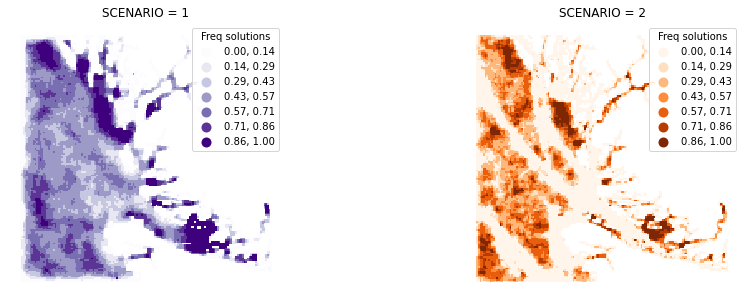

In [17]:
fig, axn = plt.subplots(1, 2, figsize=(15,5))

diff.plot(ax=axn[0], column='rel_freq1', scheme='equal_interval', 
    k=7, legend=True, cmap='Purples',
     
    legend_kwds={'title': "Freq solutions"})
diff.plot(ax=axn[1], column='rel_freq2', scheme='equal_interval', k=7, legend=True, cmap='Oranges',legend_kwds={'title': "Freq solutions"})
axn[0].set_title('SCENARIO = 1')
axn[1].set_title('SCENARIO = 2')
axn[0].set_axis_off();
axn[1].set_axis_off();


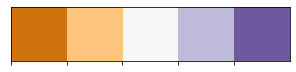

In [18]:
## Create palettes
n_categories = 3
full_palette = sns.color_palette('PuOr', n_colors=(n_categories - 1) * 2 + 1)
sns.palplot(full_palette)

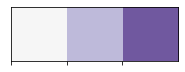

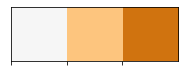

In [19]:
cmap_x = full_palette[n_categories - 1:]
sns.palplot(cmap_x)
cmap_y = list(reversed(full_palette))[n_categories - 1:]
sns.palplot(cmap_y)

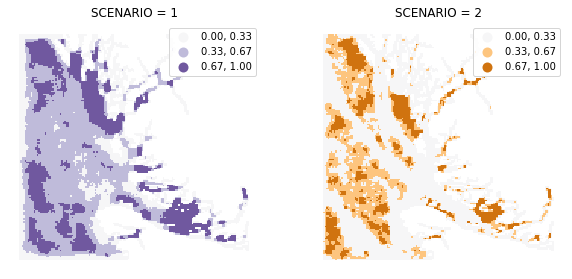

In [20]:
# creamos la figura
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

diff.plot(ax=ax[0], column='rel_freq1', scheme='equal_interval', k=n_categories, cmap=ListedColormap(cmap_x),
           legend=True)
diff.plot(ax=ax[1], column='rel_freq2', scheme='equal_interval', k=n_categories, cmap=ListedColormap(cmap_y),
           legend=True)
ax[0].set_title('SCENARIO = 1')
ax[0].set_axis_off();
ax[1].set_title('SCENARIO = 2')
ax[1].set_axis_off();

In [21]:
def colorFromBivariateData(Z1,Z2, cmap1 = plt.cm.Purples, cmap2 = plt.cm.Oranges, preset = False):

    if preset:
        z1mn = 0.
        z2mn = 0.
        z1mx = 1.
        z2mx = 1.
    else:
        z1mn = Z1.min()
        z2mn = Z2.min()
        z1mx = Z1.max()
        z2mx = Z2.max()        
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-z1mn)/(z1mx-z1mn), dtype=int)
    Z2_plot = np.array(255*(Z2-z2mn)/(z2mx-z2mn), dtype=int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color


In [22]:
def bivariate_palette(elm)-> dict:
    '''
    
    Parameters
    ----------
    elm : np.Array 3D array of values

    '''
    bivariate_palette = {}
    i, j = 0, 0
    shape = elm.shape

    for el in elm.reshape(shape[0]*shape[1],shape[2]): 
        bivariate_palette[(i, j)] = rgb2hex(el)
        j+=1
        if j == shape[1]:
            j = 0
            i += 1
    return bivariate_palette

In [23]:

def bivariateLegend(x:int, y:int, cmap1: LinearSegmentedColormap = plt.cm.Purples, cmap2: LinearSegmentedColormap = plt.cm.Oranges):
    '''
    creates a bivariate legend

    Parameters
    ----------
    x : int number of categories in x
    y : int number of categories in y
    cmap1 : LinearSegmentedColormap colormap for x
    cmap2 : LinearSegmentedColormap colormap for y

    Returns
    -------
    fig : matplotlib figure
    '''
    xx, yy = np.mgrid[0:x,0:y]
    C_map = colorFromBivariateData(xx,
            yy, 
            cmap1,
            cmap2,
            preset = False)
    ax = plt.imshow(C_map, origin='lower')

    ax.axes.set_xlabel('Freq 1')
    ax.axes.set_ylabel('Freq 2')
    #ax.axes.set_ylim((-0.5,0.5+(yy.max()-yy.min())))     

    return ax, bivariate_palette(C_map), C_map

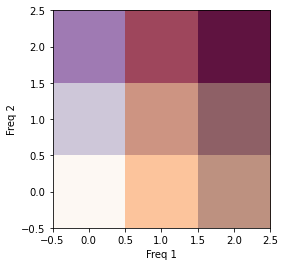

In [24]:
ax, palette, C_map = bivariateLegend(n_categories,n_categories)

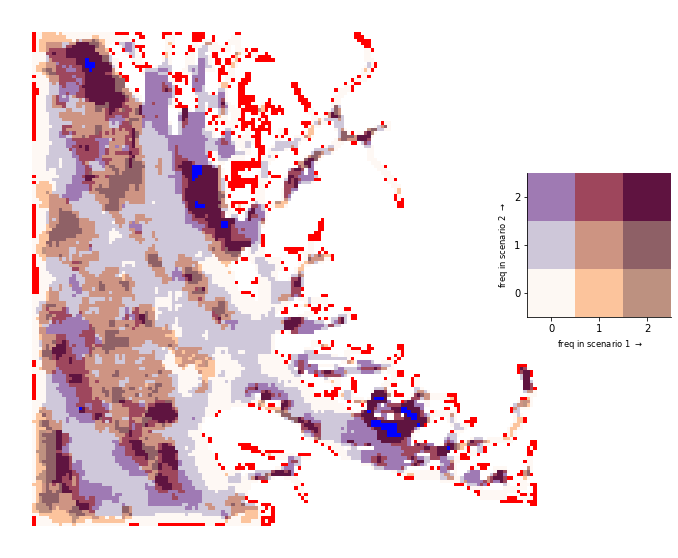

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
scen1_bin = mapclassify.EqualInterval(diff['rel_freq1'], k = n_categories)
scen2_bin = mapclassify.EqualInterval(diff['rel_freq2'], k = n_categories)
# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for i in range(n_categories):
    for j in range(n_categories):
        # buscamos las áreas que tienen ambos valores de categoría
        areas_in_this_category = set(np.where(scen1_bin.yb == i)[0]) & set(np.where(scen2_bin.yb == j)[0])
        diff.iloc[list(areas_in_this_category)].plot(
            color=palette[(i, j)], ax=ax, edgecolor='none')

diff[diff['category']=='always'].plot(color='blue', ax=ax, edgecolor='none') ### add 1-1
diff[diff['category']=='never'].plot(color='red', ax=ax, edgecolor='none') ### add 0-0
        
ax.set_axis_off()

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.85, .45, .2, .2], facecolor='y')
a.imshow(C_map, origin='lower')
a.set_xlabel('freq in scenario 1 $\\rightarrow$', fontsize='small')
a.set_ylabel('freq in scenario 2 $\\rightarrow$', fontsize='small')
a.set_xticks([0,1,2])
a.set_yticks([0,1,2])
sns.despine(ax=a)

### Bivariate variant with difference and Frequency

In [94]:
n,m = 5, 3

In [95]:
diff['diff']=((diff['rel_freq1']-diff['rel_freq2']))
diff['freq_abs']=np.maximum.reduce(diff[['rel_freq1', 'rel_freq2']].values, axis=1)
diff.head()

,PUID,geometry,planning_unit,freq1,freq2,rel_freq1,rel_freq2,category,diff,freq_abs
0,1,"POLYGON ((732060.000 578650.001, 732060.000 58...",1,0,0,0.00,0.0,never,0.00,0.0
1,2,"POLYGON ((734060.000 578650.001, 734060.000 58...",2,0,1,0.00,0.1,both,-0.10,0.1
2,3,"POLYGON ((736060.000 578650.001, 736060.000 58...",3,0,3,0.00,0.3,both,-0.30,0.3
3,4,"POLYGON ((738060.000 578650.001, 738060.000 58...",4,0,1,0.00,0.1,both,-0.10,0.1
4,5,"POLYGON ((740060.000 578650.001, 740060.000 58...",5,1,1,0.03,0.1,both,-0.07,0.1


Text(0, 0.5, 'max freq $\\rightarrow$')

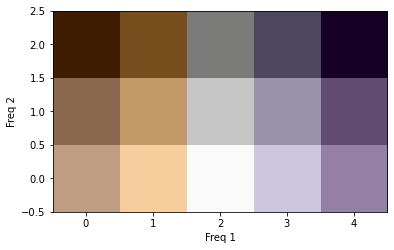

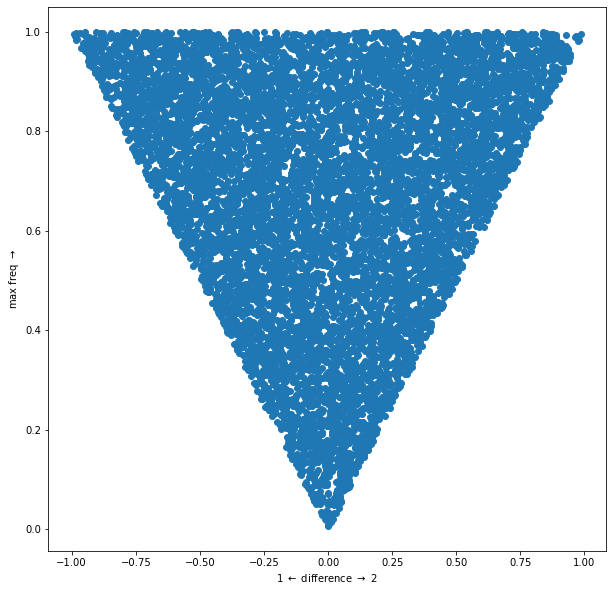

In [102]:
ax, palette, C_map = bivariateLegend(m,n, cmap2=plt.cm.PuOr, cmap1=plt.cm.Greys)
scen1_bin = mapclassify.EqualInterval(diff['diff'], k = n)
scen2_bin = mapclassify.EqualInterval(diff['freq_abs'], k = m)

def f(x, y):
    return x - y
def lm(x, y):
    return np.where(x >= y, x, y)
rng = np.random.default_rng()

x = rng.random(10000)
y = rng.random(10000)

diff = f(x,y)
freq = lm(x,y)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(diff, freq)
ax.set_xlabel('1 $\\leftarrow$ difference $\\rightarrow$ 2')
ax.set_ylabel('max freq $\\rightarrow$')

In [103]:
scen1_bin

EqualInterval         

   Interval      Count
----------------------
[-0.93, -0.54] |    44
(-0.54, -0.16] |  1035
(-0.16,  0.23] |  5486
( 0.23,  0.61] |  4678
( 0.61,  1.00] |   935

array([0.74901961, 0.61568627, 0.51568627, 1.        ])

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


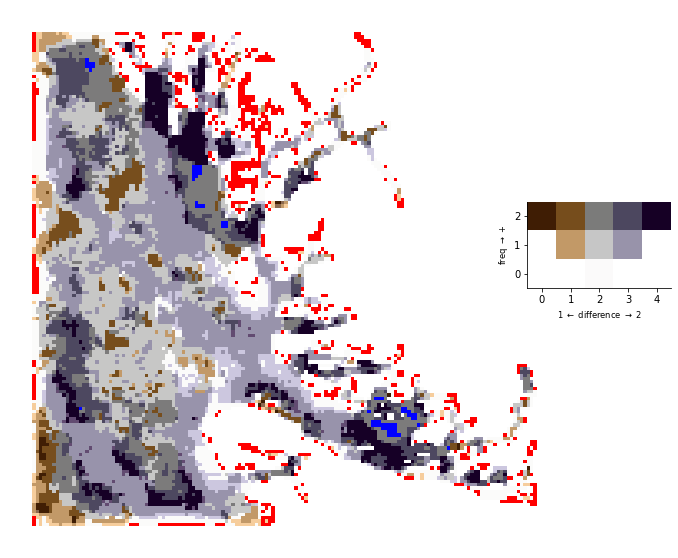

In [101]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# ahora hacemos iteraciones anidadas, porque queremos las combinaciones de dos categorías
for i in range(m):
    for j in range(n):
        # buscamos las áreas que tienen ambos valores de categoría
        areas_in_this_category = set(np.where(scen2_bin.yb == i)[0]) & set(np.where(scen1_bin.yb == j)[0])
        diff.iloc[list(areas_in_this_category)].plot(
            color=palette[(i, j)], ax=ax, edgecolor='none')

diff[diff['category']=='always'].plot(color='blue', ax=ax, edgecolor='none') ### add 1-1
diff[diff['category']=='never'].plot(color='red', ax=ax, edgecolor='none') ### add 0-0
        
ax.set_axis_off()

# dibujamos la leyenda. el parámetro de axes es la posición (x, y) y el ancho (width, height) de la leyenda.
a = fig.add_axes([.85, .45, .2, .2], facecolor='y')
# we will remove colors that will not provide information for the inverted piramid distribution
whiteRGB = [1,1,1,1]
C_map[0,0] = whiteRGB
C_map[1,0] = whiteRGB
C_map[0,1] = whiteRGB
C_map[0,4] = whiteRGB
C_map[1,4] = whiteRGB
C_map[0,3] = whiteRGB

a.imshow(C_map, origin='lower')
a.set_ylabel('freq $\\rightarrow$ +', fontsize='small')
a.set_xlabel('1 $\\leftarrow$ difference $\\rightarrow$ 2', fontsize='small')
a.set_yticks(np.arange(m))
a.set_xticks(np.arange(n))
sns.despine(ax=a)

## Diference between scenarios.

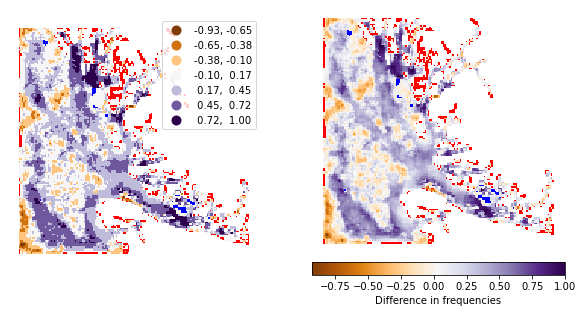

In [55]:
diff['diff']=((diff['rel_freq1']-diff['rel_freq2']))
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.1)

diff.plot(column="diff", cmap='PuOr', legend=True, ax=ax[0],scheme='equal_interval', k=7)
diff.plot(column="diff", cmap='PuOr', legend=True, ax=ax[1], cax=cax,legend_kwds={'label': "Difference in frequencies",
                        'orientation': "horizontal"})

for pos in [0,1]:
    diff[diff['category']=='always'].plot(color='blue', ax=ax[pos], edgecolor='none') ### add 1-1
    diff[diff['category']=='never'].plot(color='red', ax=ax[pos], edgecolor='none') ### add 0-0
    ax[pos].set_axis_off()

## Difference Map Function (Old - with many categories)
[Reference paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002586)

#### Categories:
- never : Never selected in any of the scenarios
- always : Always selected in both scenarios (can include locked in areas in both scenarios)
- S1_always : Always selected only in S1 (can include locked in areas in S1)
- S2_always : Always selected only in S2 (can include locked in areas in S2)
- S1_only: Only selected in S1 (excluding pus already in *always* or *S1_always*. This can be representd as frequency on map insted of one color to highlight areas that are selected moreoften)
- S2_only: Only selected in S2 (excluding pus already in *always* or *S1_always*. This can be representd as frequency on map insted of one color to highlight areas that are selected moreoften)
- both_comparable: PUs selected in both scenarios with comparable frequency [the absolute difference of the relative frequencies is below 10% (relfreqS1 - relfreqS2 < 0.1)]
- both_higherS1: PUs selected in both scenarios BUT with higher frequency in S1 [the difference of the relative frequencies is above 10% (relfreqS1 - relfreqS2 > 0.1)]
- both_higherS2: PUs selected in both scenarios BUT with higher frequency in S2 [the difference of the relative frequencies is above 10% (relfreqS1 - relfreqS2 < -0.1)]

In [408]:
## validating files will depend on needs of the DB
## Output will depend on the needs of the DB (now ouputing as DF, but could be a dict {pu:category})

def diffMap(SCEN1_PATH: str,SCEN2_PATH: str, show_count: bool)-> dict:
# 1. Read files (input.dat, pu.dat, pu_grid)
    MARXAN_INPUTDATA = 'input.dat'
    # Input files
    input1 = readInput(SCEN1_PATH,MARXAN_INPUTDATA)
    input2 = readInput(SCEN2_PATH,MARXAN_INPUTDATA)
    
    #pu.dat files
    pu1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, planningUnits)
    pu2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, planningUnits)
    
    ## Frequency of solutions output file
    s1 = validateFile(SCEN1_PATH,MARXAN_INPUTDATA, OutputSsoln)
    s2 = validateFile(SCEN2_PATH,MARXAN_INPUTDATA, OutputSsoln)

    ## Number of runs
    n1 = int(input1.NUMREPS)
    n2 = int(input2.NUMREPS)
    
# 2. Rename fields and merge with grid 
    # freq = the total number of times a pu has been selected in all solutions
    diff= s1.rename(columns={'number':'freq1'})
    diff['freq2'] = s2.number

    # rel_freq = freq/number of solutions (different scenarios may have different solution number)
    diff['rel_freq1'] = round(diff.freq1/n1,2)
    diff['rel_freq2'] = round(diff.freq2/n2,2)

    # diff = selection of scenario 1 - scenario 2
    # dif_abs = absolute difference 
    diff['diff'] = diff.rel_freq1  - diff.rel_freq2
    diff['diff_abs'] = diff['diff'].abs()

    # pu.dat get status
    pu1 = pu1.rename(columns={'status':'status1'})
    pu1['status2'] = pu2.status

# 3. Assign categories
    # Never selected in S1 & S2
    never = list(diff[(diff['rel_freq1'] == 0)   & (diff['rel_freq2'] == 0)].planning_unit.values)

    # Locked-in /Always
    # status 2 in pu.dat should give rel_freq=1, but that is not the case. TO DO: understand why
    lock1 = list(diff[(diff['rel_freq1'] == 1)].planning_unit.values)
    lock2 = list(diff[(diff['rel_freq2'] == 1)].planning_unit.values)
    always = list(set(lock1) & set(lock2)) # Always selected in both
    S1_always = list(set(lock1) - set(always)) # always selected in S1
    S2_always = list(set(lock2) - set(always)) # always selected in S2

    # Always selected in S1 & S2
    #always = list(diff[(diff['rel_freq1'] == 1) & (diff['rel_freq2'] == 1)].planning_unit.values)

    # Only selected in S1, but below 1
    S1_only = list(diff[(diff['rel_freq1'] != 0 ) & (diff['rel_freq2'] == 0)].planning_unit.values)
    S1_only = list(set(S1_only) - set(S1_always))

    # Only selected in S2, but below 1
    S2_only = list(diff[(diff['rel_freq1'] == 0) & (diff['rel_freq2'] != 0)].planning_unit.values)
    S2_only = list(set(S2_only) - set(S2_always))
    
    # Selected in both with comparable frequency (difference between -0.1 and 0.1)
    both_comparable = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1) & 
                            (diff['diff_abs'] <= 0.1)].planning_unit.values)

    # Selected in both with higher frequency in S1 (difference > 0.1)
    both_higherS1 = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1)  & 
                            (diff['diff'] > 0.1)].planning_unit.values)

    # Selected in both with higher frequency in S2 (difference < -0.1)
    both_higherS2 = list(diff[(diff['rel_freq1'] != 0) & 
                            (diff['rel_freq1'] < 1) &
                            (diff['rel_freq2'] != 0) & 
                            (diff['rel_freq2'] < 1)  & 
                            (diff['diff'] < -0.1)].planning_unit.values)
    
    # create dict of categories
    categories = {
         'S1_always':S1_always,
         'S1_only':S1_only,
         'both_higherS1':both_higherS1,
         'both_always':always,
         'both_comparable':both_comparable,
         'both_never': never,
         'both_higherS2':both_higherS2,
         'S2_only':S2_only,
         'S2_always':S2_always
         }
    
    diff['category']= 'NotAssigned'
    for key in categories.keys():
        diff.loc[diff['planning_unit'].isin(categories[key]),'category'] = key
        
# 4. Sanity checks
# All pu's are assigned to one category
    if show_count:
        all_pu= []
        for i in categories.keys():
            all_pu = all_pu + categories[i]
            print(f"there are {len(categories[i])} pu's assigned to {i}")
        print(f"there are {len(diff)-len(all_pu) } pu's not assigned")
    
    # Covert to dict (this format can be more elaborate depending on FE requirements)
    diff_dict =diff[['planning_unit','category','diff','diff_abs']].to_dict()
    
    return diff_dict

In [409]:
def plotDiffMap(diff_dict: dict,GRID_PATH: str, solid: bool):
    # grid file
    pu_grid = gpd.read_file(f'{GRID_PATH}')
    
    # convert dict to dataframe
    diff = pd.DataFrame.from_dict(diff_dict,orient='columns')
    
    # merge with pu grid
    diff = pu_grid[['PUID','geometry']].merge(diff,left_on='PUID',right_on ='planning_unit',how='inner')
    
    # Plot as solid colors or frequency 
    diff.plot(column = 'category',legend =True,figsize =(10,10), colormap='tab20')

In [410]:
SCEN1_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario2'
SCEN2_PATH = '/home/jovyan/work/datasets/raw/Marxan_DiffMap/Scenario3'
GRID_PATH = f'{SCEN1_PATH}/pu/pulayer.shp'
diff = diffMap(SCEN1_PATH,SCEN2_PATH, show_count =True)

there are 218 pu's assigned to S1_always
there are 4891 pu's assigned to S1_only
there are 4438 pu's assigned to both_higherS1
there are 7 pu's assigned to both_always
there are 900 pu's assigned to both_comparable
there are 817 pu's assigned to both_never
there are 679 pu's assigned to both_higherS2
there are 187 pu's assigned to S2_only
there are 41 pu's assigned to S2_always
there are 0 pu's not assigned


### Plot Difference Map

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:630: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  warnings.warn(


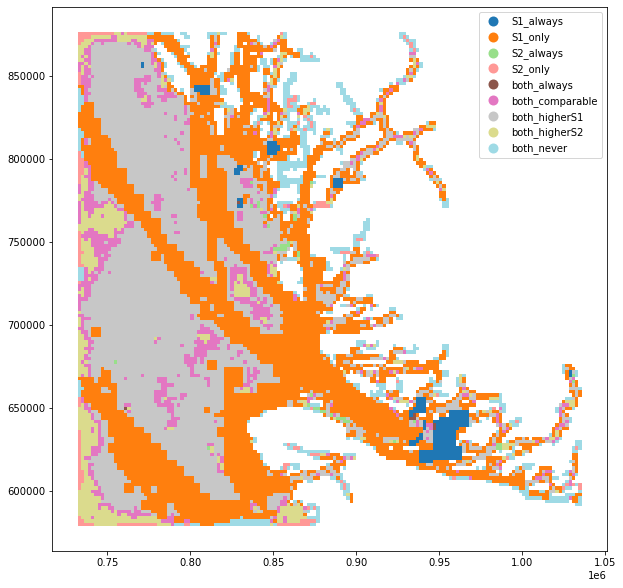

In [411]:
# Each category as solid color
plotDiffMap(diff,GRID_PATH, solid= True )

Text(0, 0.5, 'max freq $\\rightarrow$')

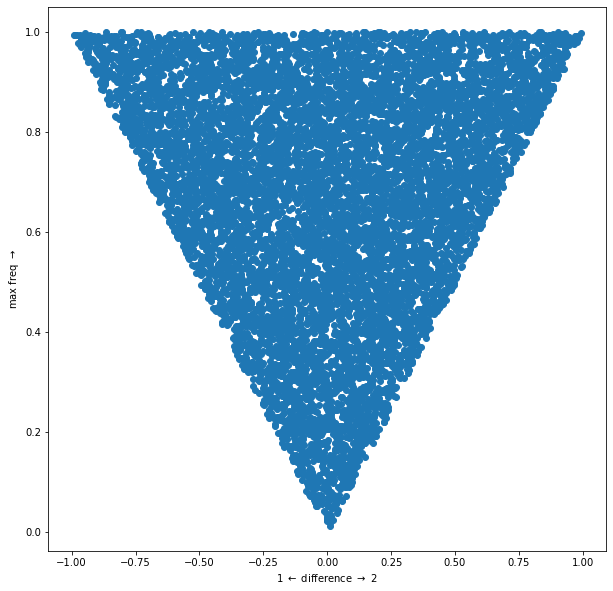

In [72]:
 

vals = rng.standard_normal(10)
more_vals = rng.standard_normal(10)

In [73]:
vals

array([ 0.09822649, -0.18260089,  1.74476399, -1.22859596,  1.79747745,
       -0.93358413, -1.29116929,  2.51755751,  1.0954635 ,  0.13832308])

In [74]:
more_vals

array([-1.45265733, -0.37817261, -0.05503495,  0.60457327,  1.4669854 ,
        0.88989972,  1.98760868, -0.36936179, -0.06611239, -1.34517071])